In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime

from keras import *
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam #não roda sem o tensorflow.keras
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

#Dados de treino e validação
IMAGE_LIB = '/home/yana/Documentos/U-net/2d_images/'
MASK_LIB = '/home/yana/Documentos/U-net/2d_masks/'


# Dados de teste
IMAGE_TEST_LIB = '/home/yana/Documentos/U-net/2d_images_test/'
MASK_TEST_LIB = '/home/yana/Documentos/U-net/2d_masks_test/'

epochs = 50 #manually cnanged
patience=40
batch = 32
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)

IMG_HEIGHT, IMG_WIDTH = 80, 80 # Perguntar se é arbitrário
#results_output = f'all_results_{epochs}_epochs_ES_{patience}_batch_{batch}_imgsize_{IMG_HEIGHT}.csv'
results_output = 'last_exec_tomos.csv'


SEED= int(datetime.datetime.now().second)
print(f'Seed: {SEED}')

all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32') #IMREAD_UNCHANGED: manutenção do canal alfa
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4) #Interpolação de Lanczos
    im = (im - np.min(im)) / (np.max(im) - np.min(im)) #Transformando a escala dos pixels para valores entre 0 e 1
    x_data[i] = im


y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST) #Interpolação por nearest-neighbor
    y_data[i] = im


print('\nMatriz original: ', x_data.shape)

x_data = x_data[:,:,:,np.newaxis] #redimensiona a matriz 
y_data = y_data[:,:,:,np.newaxis]

print('\nMatriz redimensionada: ', x_data.shape)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2) #20% do volume de dados para validação e 80% para treino

print('\nDados de Treino: ', x_train.shape)
print('\nDados de Validação: ', x_val.shape)

def dice_coef(y_true, y_pred): #Sørensen–Dice coefficient
    y_true_f = K.flatten(y_true) #transformando em unidimensional
    y_pred_f = K.flatten(y_pred) #transformando em unidimensional
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + \
        K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon()) #2*|X ∩ Y|/ |X|+|Y| 
    #K.epsilon() retorna o fuzz factor evitando divisão por zero

#Tabela Dices - Por Tomo
mean_list = []
median_list = []
std_list = []
max_list = []
min_list = []

number_of_exec = 1 #manually cnanged

input_layer = Input(shape=x_train.shape[1:]) #somente dimensões

c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1) 
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)

l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)

output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l) 
                                                        
model = Model(input_layer, output_layer)

#Data Augmentation
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED) #salvando no diretório? batch-size, seed?
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

model.compile(optimizer=Adam(2e-4), \
    loss='binary_crossentropy', metrics=[dice_coef]) 


weight_saver = ModelCheckpoint('lung.h5',\
    monitor='val_dice_coef', save_best_only=True, \
        save_weights_only=True)

newLearningRate = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x) 


hist = model.fit_generator(my_generator(x_train, y_train, batch),
                        steps_per_epoch = 200,
                        validation_data = (x_val, y_val),
                        epochs=epochs, verbose=2,
                        callbacks = [weight_saver, newLearningRate, early_stopping])

model.load_weights('lung.h5')

#Trabalhando com os dados de teste (20%)

all_test_images = [x for x in sorted(os.listdir(IMAGE_TEST_LIB)) if x[-4:] == '.tif']
x_test = np.empty((len(all_test_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')

for i, name in enumerate(all_test_images):
    im = cv2.imread(IMAGE_TEST_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32') 
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4) 
    im = (im - np.min(im)) / (np.max(im) - np.min(im)) 
    x_test[i] = im


y_test = np.empty((len(all_test_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_test_images):
    im = cv2.imread(MASK_TEST_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST) 
    y_test[i] = im

x_test = x_test[:,:,:,np.newaxis] #redimensiona a matriz 
y_test = y_test[:,:,:,np.newaxis]

y_hat = model.predict(x_test)

#interna 
dice_all_tomos = []
diceOrder = []
for i in range(y_hat.shape[0]):
  dicePerTomo = float(dice_coef(y_test[i], y_hat[i]))
  dice_all_tomos.append(dicePerTomo)

  n = (f'Tomo {i+1}')
  diceOrder.append(n)
df_dice = pd.DataFrame(dice_all_tomos, diceOrder).reset_index()
df_dice.columns = {'','Values'}
df_dice.to_excel('tomos_last_exec_data.xlsx')


diceValuesList = []

for i in range(y_hat.shape[0]):
    dicePerTomo = float(dice_coef(y_test[i], y_hat[i]))
    diceValuesList.append(dicePerTomo)

dict_to_data ={'exec':number_of_exec,'seed':SEED,'mean':np.mean(diceValuesList), \
    'median':np.median(diceValuesList), \
    'std':np.std(diceValuesList), 'max':np.max(diceValuesList), 'min':np.min(diceValuesList), 'epochs':epochs, 'patience':patience, \
    'batch':batch, 'img_size':IMG_HEIGHT}
exec_moment = str(datetime.datetime.now()).replace(':','-').replace(' ','-')
df_stat = pd.DataFrame(dict_to_data, index=[number_of_exec])

if (number_of_exec==1):
    df_stat.to_csv(results_output)
else: 
    df_stat.to_csv(results_output, mode = 'a', header = False)


Seed: 17

Matriz original:  (214, 80, 80)

Matriz redimensionada:  (214, 80, 80, 1)

Dados de Treino:  (171, 80, 80, 1)

Dados de Validação:  (43, 80, 80, 1)


2023-02-11 12:02:19.681856: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 12:02:19.703537: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/yana/anaconda3/envs/UnetSegmentation/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-11 12:02:20.588705: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are en

Epoch 1/50
200/200 - 79s - loss: 0.3512 - dice_coef: 0.5186 - val_loss: 0.1149 - val_dice_coef: 0.8487
Epoch 2/50
200/200 - 76s - loss: 0.1351 - dice_coef: 0.8410 - val_loss: 0.0930 - val_dice_coef: 0.8869
Epoch 3/50
200/200 - 74s - loss: 0.1082 - dice_coef: 0.8746 - val_loss: 0.0675 - val_dice_coef: 0.9096
Epoch 4/50
200/200 - 73s - loss: 0.0969 - dice_coef: 0.8888 - val_loss: 0.0574 - val_dice_coef: 0.9202
Epoch 5/50
200/200 - 72s - loss: 0.0902 - dice_coef: 0.8977 - val_loss: 0.0543 - val_dice_coef: 0.9240
Epoch 6/50
200/200 - 72s - loss: 0.0869 - dice_coef: 0.9000 - val_loss: 0.0510 - val_dice_coef: 0.9284
Epoch 7/50
200/200 - 71s - loss: 0.0840 - dice_coef: 0.9038 - val_loss: 0.0646 - val_dice_coef: 0.9153
Epoch 8/50
200/200 - 71s - loss: 0.0818 - dice_coef: 0.9055 - val_loss: 0.0577 - val_dice_coef: 0.9232
Epoch 9/50
200/200 - 71s - loss: 0.0813 - dice_coef: 0.9071 - val_loss: 0.0512 - val_dice_coef: 0.9289
Epoch 10/50
200/200 - 79s - loss: 0.0797 - dice_coef: 0.9080 - val_loss: 

(-0.5, 79.5, 79.5, -0.5)

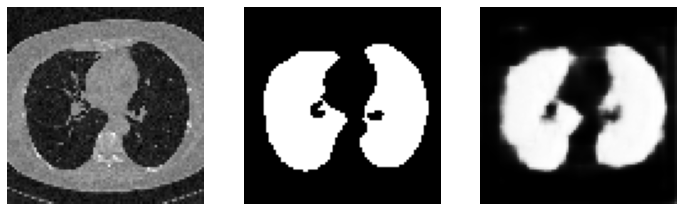

In [15]:
# Tomo with highest dice 
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_test[41,:,:,0], cmap='gray')
ax[1].imshow(y_test[41,:,:,0], cmap='gray')
ax[2].imshow(y_hat[41,:,:,0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

(-0.5, 79.5, 79.5, -0.5)

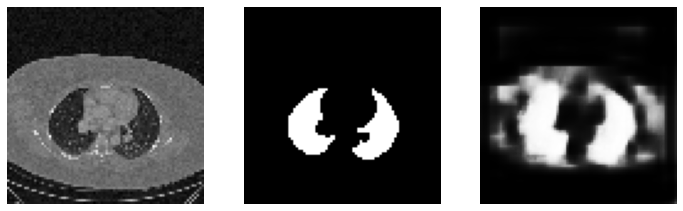

In [17]:
# Tomo with smallest dice
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_test[46,:,:,0], cmap='gray')
ax[1].imshow(y_test[46,:,:,0], cmap='gray')
ax[2].imshow(y_hat[46,:,:,0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [20]:
from skimage.io import imshow

ValueError: not enough values to unpack (expected 4, got 2)

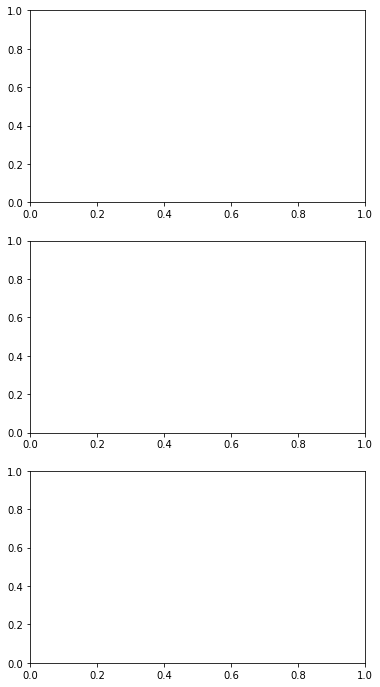

In [23]:
fig, ax1, ax2, ax3 = plt.subplots(3,1,figsize=(6,12))
ax1.imshow(x_test[46,:,:,0], cmap='gray')
ax2.imshow(y_test[46,:,:,0], cmap='gray')
ax3.imshow(y_hat[46,:,:,0], cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
